# Hyperparameter testing
Repurposes sections of Yu-Chiao's original amv_prediction script

In [43]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import sys
import os

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from time import time

In [44]:
run_flag = 1

In [45]:
def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

class AMV_dataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        
        self.fc1 = nn.Linear(16 * 12 * 21, 24)
        self.fc2 = nn.Linear(24, 20)
        self.fc3 = nn.Linear(20, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 12 * 21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

def train_network(net, criterion, optimizer, trainloader, testloader, 
                  experiment_name, num_epochs=50, printprogress=True):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      if printprogress:
          print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                                running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses

if run_flag == 1:
   plt.close('all')

In [6]:
# ================================================================
# Read data
# ================================================================
ens_sel = 10
time_lag = 0

# Load labeled data (SST)
dirname = '/stormtrack/data4/share/deep_learning/data/'
#   filename = 'DampingTerm_NAtl_1920_2005_EnsAll.nc'
filename = 'CESM1LE_SST_Anomaly_NAtl_1920_2005_EnsAll.nc'
ds = xr.open_dataset(dirname + filename, decode_times=True)
#   var_tmp1 = ds['Damping_Term'][:,:,:,:].data.copy()
var_tmp1 = ds['SST'][:,:,:,:].data.copy()
lat = ds["lat"][:].data.copy()
lon = ds["lon"][:].data.copy()
ds.close()

# Load labeled data (Damping)
dirname = '/stormtrack/data4/share/deep_learning/data/'
filename = 'DampingTerm_NAtl_1920_2005_EnsAll.nc'
ds = xr.open_dataset(dirname + filename, decode_times=True)
var_tmp3 = ds['Damping_Term'][:,:,:,:].data.copy()
ds.close()

# Get dimension sizes
ny = len(lat)
nx = len(lon)
ens_num = var_tmp1.shape[0]
nt = var_tmp1.shape[1]

# Make Land/Ice mask 
mask1 = np.sum(np.sum(var_tmp1, axis=0), axis=0)
mask1 = mask1/mask1

# Load in SST again?
dirname = '/stormtrack/data4/share/deep_learning/data/'
filename = 'CESM1LE_SST_Anomaly_NAtl_1920_2005_EnsAll.nc'
ds = xr.open_dataset(dirname + filename, decode_times=True)
var_tmp2 = ds['SST'][:,:,:,:].data.copy()
ds.close()

mask2 = np.sum(np.sum(var_tmp2, axis=0), axis=0)
mask2 = mask2/mask2
mask_all = mask1*mask2

# Set nan values to zero
var_tmp1[np.isnan(var_tmp1)] = 0.
var1_comb = np.zeros((nt,time_lag+1,ny,nx))
var_ts = np.zeros((nt))

for NT in range(nt):
   var1_comb[NT,0,:,:] = var_tmp1[ens_sel,NT,:,:]
   var_ts[NT] = np.nanmean(var_tmp2[ens_sel,NT,:,:])

var_tmp3[np.isnan(var_tmp3)] = 0.
var3_comb = np.zeros((nt,time_lag+1,ny,nx))
for NT in range(nt):
   var3_comb[NT,0,:,:] = var_tmp3[ens_sel,NT,:,:]

train Set: Epoch 01. loss: 0.022057
test Set: Epoch 01. loss: 0.032573
train Set: Epoch 02. loss: 0.018029
test Set: Epoch 02. loss: 0.029804
train Set: Epoch 03. loss: 0.015467
test Set: Epoch 03. loss: 0.024258
train Set: Epoch 04. loss: 0.011202
test Set: Epoch 04. loss: 0.015909
train Set: Epoch 05. loss: 0.006041
test Set: Epoch 05. loss: 0.007194
train Set: Epoch 06. loss: 0.002385
test Set: Epoch 06. loss: 0.003166
train Set: Epoch 07. loss: 0.001194
test Set: Epoch 07. loss: 0.001926
train Set: Epoch 08. loss: 0.000827
test Set: Epoch 08. loss: 0.001413
train Set: Epoch 09. loss: 0.000654
test Set: Epoch 09. loss: 0.001132
train Set: Epoch 10. loss: 0.000552
test Set: Epoch 10. loss: 0.000948
train Set: Epoch 11. loss: 0.000484
test Set: Epoch 11. loss: 0.000822
train Set: Epoch 12. loss: 0.000434
test Set: Epoch 12. loss: 0.000728
train Set: Epoch 13. loss: 0.000397
test Set: Epoch 13. loss: 0.000659
train Set: Epoch 14. loss: 0.000367
test Set: Epoch 14. loss: 0.000604
train 

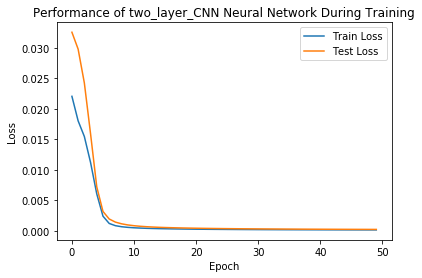

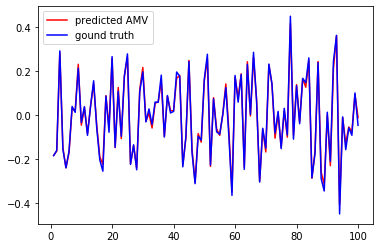

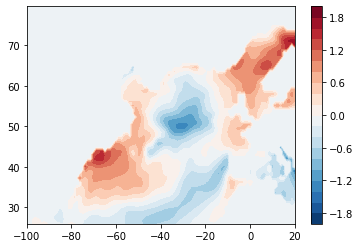

In [132]:

# ================================================================
# Train model
# ================================================================
num_input_time_steps = 1
train_predictors = var1_comb[0:800,:,:,:].astype(np.float32)
train_predictands = var_ts[0:800].astype(np.float32)
test_predictors = var1_comb[-100:,:,:,:].astype(np.float32)
test_predictands = var_ts[-100:].astype(np.float32)
test2_predictors = var3_comb[-100:,:,:,:].astype(np.float32)
test2_predictands = var_ts[-100:].astype(np.float32)

#Convert the numpy ararys into AMV_dataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = AMV_dataset(train_predictors, train_predictands)
test_dataset = AMV_dataset(test_predictors, test_predictands)
test2_dataset = AMV_dataset(test2_predictors, test2_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=5)
testloader = DataLoader(test_dataset, batch_size=5)
net = CNN(num_input_time_steps=num_input_time_steps)

#   optimizer = optim.Adam(net.parameters(), lr=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.001)

experiment_name = "two_layer_CNN"
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
              optimizer, trainloader, testloader, experiment_name)

# Plot out loss function against epoch
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')

corr, _ = pearsonr(test_predictands, predictions)
rmse    = mean_squared_error(test_predictands, predictions) ** 0.5

print("corr = ", corr)
print("rmse = ", rmse)

# Plot out predictand time series
tt = np.linspace(1,len(predictions),len(predictions)) 
plt.figure()
plt.plot(tt,predictions,'r-',label='predicted AMV')
plt.plot(tt,test_predictands,'b-',label='gound truth')
plt.legend()

#   plot_nino_time_series(test_predictands, predictions, '{} Predictions. \n Corr: {:3f}. \n RMSE: {:3f}.'.format(experiment_name, corr, rmse))

plt.figure()
plt.contourf(lon,lat,var1_comb[111,:,:,:].squeeze(), levels=np.linspace(-2,2,21),cmap='RdBu_r')
plt.colorbar()

plt.show()

## Manual Hyperparameter Testing

In [72]:
# -------------------------------------
# Manual Hyperparameter Testing: Set-up
# -------------------------------------
# Setup: Indicate hyperparameter values and set up grid. Preallocate output variables and prepare data
# Currently, only works with varying eta and wd (need to think of more generalizable code...)

# User edits start here -----------------------
# Input some hyperparameters and their values
eta = [0.0001,0.001,0.01,0.1,1]
wd  = [0.0001,0.001,0.01,0.1,1]

# Set the hyperparameter grid
param1 = eta.copy()
param2 = wd.copy()

# Set input data options
num_input_time_steps = 1
testsize = 100
trainsize = 800

# Set other variables
batch_size = 5
experiment_name = "two_layer_CNN"
num_epochs = 50

# Save data
outname = "hyperparameter_testing_wd_eta_10e-4_10e0.npz"
outpath = "/stormtrack/data4/share/deep_learning/data/hyperparameter_testing/"

# User edits stop here ------------------------


# Dimensions of target parameters
np1 = len(param1)
np2 = len(param2)
gridsize = np.array([np1,np2]) 

# Preallocate Relevant Variables...
corr_grid         = np.zeros(gridsize)
rmse_grid         = np.zeros(gridsize)
predictions_grid  = np.zeros(np.concatenate([gridsize,[testsize,]]))
train_losses_grid = np.zeros(np.concatenate([gridsize,[num_epochs,]]))
test_losses_grid  = np.zeros(train_losses_grid.shape)


# Partition the input data into train/test
train_predictors = var1_comb[0:trainsize,:,:,:].astype(np.float32)
train_predictands = var_ts[0:trainsize].astype(np.float32)
test_predictors = var1_comb[-testsize:,:,:,:].astype(np.float32)
test_predictands = var_ts[-testsize:].astype(np.float32)
test2_predictors = var3_comb[-testsize:,:,:,:].astype(np.float32)
test2_predictands = var_ts[-testsize:].astype(np.float32)

#Convert the numpy ararys into AMV_dataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = AMV_dataset(train_predictors, train_predictands)
test_dataset = AMV_dataset(test_predictors, test_predictands)
test2_dataset = AMV_dataset(test2_predictors, test2_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)



In [73]:
%%time
# --------------------------------------------
# Manual Hyperparameter Testing: Testing Loop
# --------------------------------------------

# Perform Hyperparameter testing
for i in range(np1): # Loop for Learning Rate
    eta_in = param1[i]
    for j in range(np2): # Loop for Weight Decay
        start = time()
        wd_in = param2[j]
        
        # Initialize Network
        net = CNN(num_input_time_steps=num_input_time_steps)
        
        # Set Optimizer
        optimizer = optim.SGD(net.parameters(), lr=eta_in, weight_decay=wd_in)
        
        # Train the model
#         predictions_grid[i,j,...], train_losses_grid[i,j,...], test_losses[i,j,...] = train_network(net, nn.MSELoss(), 
#                       optimizer, trainloader, testloader, experiment_name,num_epochs=num_epochs,printprogress=False)
        predictions_grid[i,j,...], train_losses, test_losses= train_network(net, nn.MSELoss(), 
              optimizer, trainloader, testloader, experiment_name,num_epochs=num_epochs,printprogress=False)

        train_losses_grid[i,j,...] = np.array(train_losses)
        test_losses_grid[i,j,...] = np.array(test_losses)
        
        # Calculate Correlation and RMSE
        corr_grid[i,j], _ = np.array(pearsonr(test_predictands, predictions_grid[i,j,...]))
        rmse_grid[i,j]    = np.array(mean_squared_error(test_predictands, predictions_grid[i,j,...]) ** 0.5)
        
        print("Completed training for learning rate %i of %i, weight decay %i of %i in %.2fs" % (i+1,np1,j,np2,time()-start))
        

Completed training for learning rate 0 of 5, weight decay 0 of 5 in 36.91s
Completed training for learning rate 0 of 5, weight decay 1 of 5 in 35.58s
Completed training for learning rate 0 of 5, weight decay 2 of 5 in 36.87s
Completed training for learning rate 0 of 5, weight decay 3 of 5 in 35.44s
Completed training for learning rate 0 of 5, weight decay 4 of 5 in 37.28s
Completed training for learning rate 1 of 5, weight decay 0 of 5 in 35.82s
Completed training for learning rate 1 of 5, weight decay 1 of 5 in 36.32s
Completed training for learning rate 1 of 5, weight decay 2 of 5 in 35.41s
Completed training for learning rate 1 of 5, weight decay 3 of 5 in 36.59s
Completed training for learning rate 1 of 5, weight decay 4 of 5 in 35.24s
Completed training for learning rate 2 of 5, weight decay 0 of 5 in 36.83s
Completed training for learning rate 2 of 5, weight decay 1 of 5 in 35.28s
Completed training for learning rate 2 of 5, weight decay 2 of 5 in 36.74s
Completed training for le

/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Completed training for learning rate 3 of 5, weight decay 4 of 5 in 42.38s


/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Completed training for learning rate 4 of 5, weight decay 0 of 5 in 36.01s


/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Completed training for learning rate 4 of 5, weight decay 1 of 5 in 35.35s


/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Completed training for learning rate 4 of 5, weight decay 2 of 5 in 37.34s


/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Completed training for learning rate 4 of 5, weight decay 3 of 5 in 42.07s
Completed training for learning rate 4 of 5, weight decay 4 of 5 in 35.28s
CPU times: user 3h 38min 31s, sys: 4h 38min 54s, total: 8h 17min 25s
Wall time: 15min 32s


/home/glliu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [77]:
%%time

# -------------------------------------
# Manual Hyperparameter Testing: Save
# -------------------------------------

# Save Data
np.savez(outpath+outname,
         predictions_grid,
         train_losses_grid,
         test_losses_grid,
         corr_grid,
         rmse_grid
        )
print("Saved data to %s%s"%(outpath,outname))

Saved data to /stormtrack/data4/share/deep_learning/data/hyperparameter_testing/hyperparameter_testing_wd_eta_10e-4_10e0.npz
CPU times: user 8.81 ms, sys: 0 ns, total: 8.81 ms
Wall time: 6.76 ms


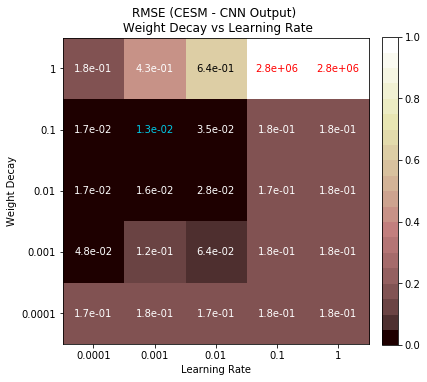

In [122]:
# -----------------------------------------
# Manual Hyperparameter Testing: Visualize
# -----------------------------------------
import matplotlib.patheffects as path_effects
figpath = outpath

# Plot the RMSE grid
data = rmse_grid.copy()
cmap = plt.get_cmap("pink",20)
cmap.set_bad(np.array([0,255,0])/255)
fig,ax = plt.subplots(1,1,figsize=(6,6))
im = ax.imshow(data,vmin=0,vmax=1,cmap=cmap)
ax.set_title("RMSE (CESM - CNN Output) \n Weight Decay vs Learning Rate")
ax.set_xticks(np.arange(0,5))
ax.set_yticks(np.arange(0,5))
ax.set_xticklabels(param1)
ax.set_yticklabels(param2)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Weight Decay")
plt.gca().invert_yaxis()
plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
# Loop over data dimensions and create text annotations.
for i in range(np1):
    for j in range(np2):
        # Set color to black if above threshold, white otherwise
        if data[i,j] > 0.6:
            usecolor='k'
        else:
            usecolor='w'
        
        if data[i,j] == np.nanmax(data): # Max in Red
            usecolor='r'
        elif data[i,j] == np.nanmin(data): # Min in Blue
            usecolor= np.array([0,202,231])/255
        
        text = ax.text(j, i, "%.1e"%data[i, j],
                       ha="center", va="center", color=usecolor)
        
        #text.set_path_effects([path_effects.Stroke(linewidth=0.25,foreground='k')])
plt.savefig("%sRMSE.png"%outpath,dpi=200)



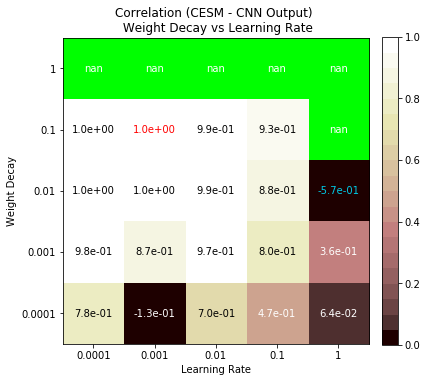

In [131]:
# Plot the Correlation grid

data = corr_grid.copy()
cmap = plt.get_cmap("pink",20)
cmap.set_bad(np.array([0,255,0])/255)
fig,ax = plt.subplots(1,1,figsize=(6,6))
im = ax.imshow(data,vmin=0,vmax=1,cmap=cmap)
ax.set_title("Correlation (CESM - CNN Output) \n Weight Decay vs Learning Rate")
ax.set_xticks(np.arange(0,5))
ax.set_yticks(np.arange(0,5))
ax.set_xticklabels(param1)
ax.set_yticklabels(param2)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Weight Decay")
plt.gca().invert_yaxis()
plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
# Loop over data dimensions and create text annotations.
for i in range(np1):
    for j in range(np2):
        # Set color to black if above threshold, white otherwise
        if data[i,j] > 0.6:
            usecolor='k'
        else:
            usecolor='w'
        
        if data[i,j] == np.nanmax(data): # Max in Red
            usecolor='r'
        elif data[i,j] == np.nanmin(data): # Min in Blue
            usecolor= np.array([0,202,231])/255
        
        text = ax.text(j, i, "%.1e"%data[i, j],
                       ha="center", va="center", color=usecolor)
        
        #text.set_path_effects([path_effects.Stroke(linewidth=0.25,foreground='k')])
plt.savefig("%sCorr.png"%outpath,dpi=200)

In [138]:
# Plot Train and Test Loss Plots


p1val = 
p2val = 

param1.index(0.001)

2

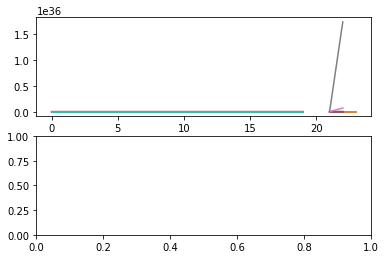

In [145]:
# For learning rate, plot the train loss

fig,ax = plt.subplots(2,1,figsize=(6,4))
